<a href="https://colab.research.google.com/github/gmrdns03/MachineLearning_Minkyo/blob/main/%5Bsklearn%5DTitanic_Classicfication_Ensemble_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 문제정의:
타이타닉 생존자 예측 데이터셋 사용하여 유무를 예측하는 이진분류 문제로 정의 <br>
사망: 0, 생존: 1

## 기본 라이브러리 임포트

In [1]:
# Libraries for reading and handling the data
import numpy as np
import pandas as pd
import re  # 정규식 쓰는 라이브러리

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Libraries for creating ML model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Library for Analysing the ML model
from sklearn import metrics

## 데이터 준비하기

In [2]:
train_path = 'train.csv'
target = 'Survived'
index = 'PassengerId'

# 가지고 올 때 원하는 타입으로 세팅해서 불러올 수도 있다.
dtypes = ({
    'Survived': bool, 
    'Pclass':   'category', 
    'Name':     'category',
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})

titanic = pd.read_csv(train_path, index_col=index, dtype=dtypes)

In [3]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    bool    
 1   Pclass    891 non-null    category
 2   Name      891 non-null    category
 3   Sex       891 non-null    category
 4   Age       714 non-null    float64 
 5   SibSp     891 non-null    int64   
 6   Parch     891 non-null    int64   
 7   Ticket    891 non-null    category
 8   Fare      891 non-null    float64 
 9   Cabin     204 non-null    category
 10  Embarked  889 non-null    category
dtypes: bool(1), category(6), float64(2), int64(2)
memory usage: 122.2 KB


## 데이터 시각화

In [5]:
titanic["Survived"].value_counts()

False    549
True     342
Name: Survived, dtype: int64

사망이나 생존에 대해서는 어떤 특징을 가지고 있어야 하는 지 먼저 분석해보기

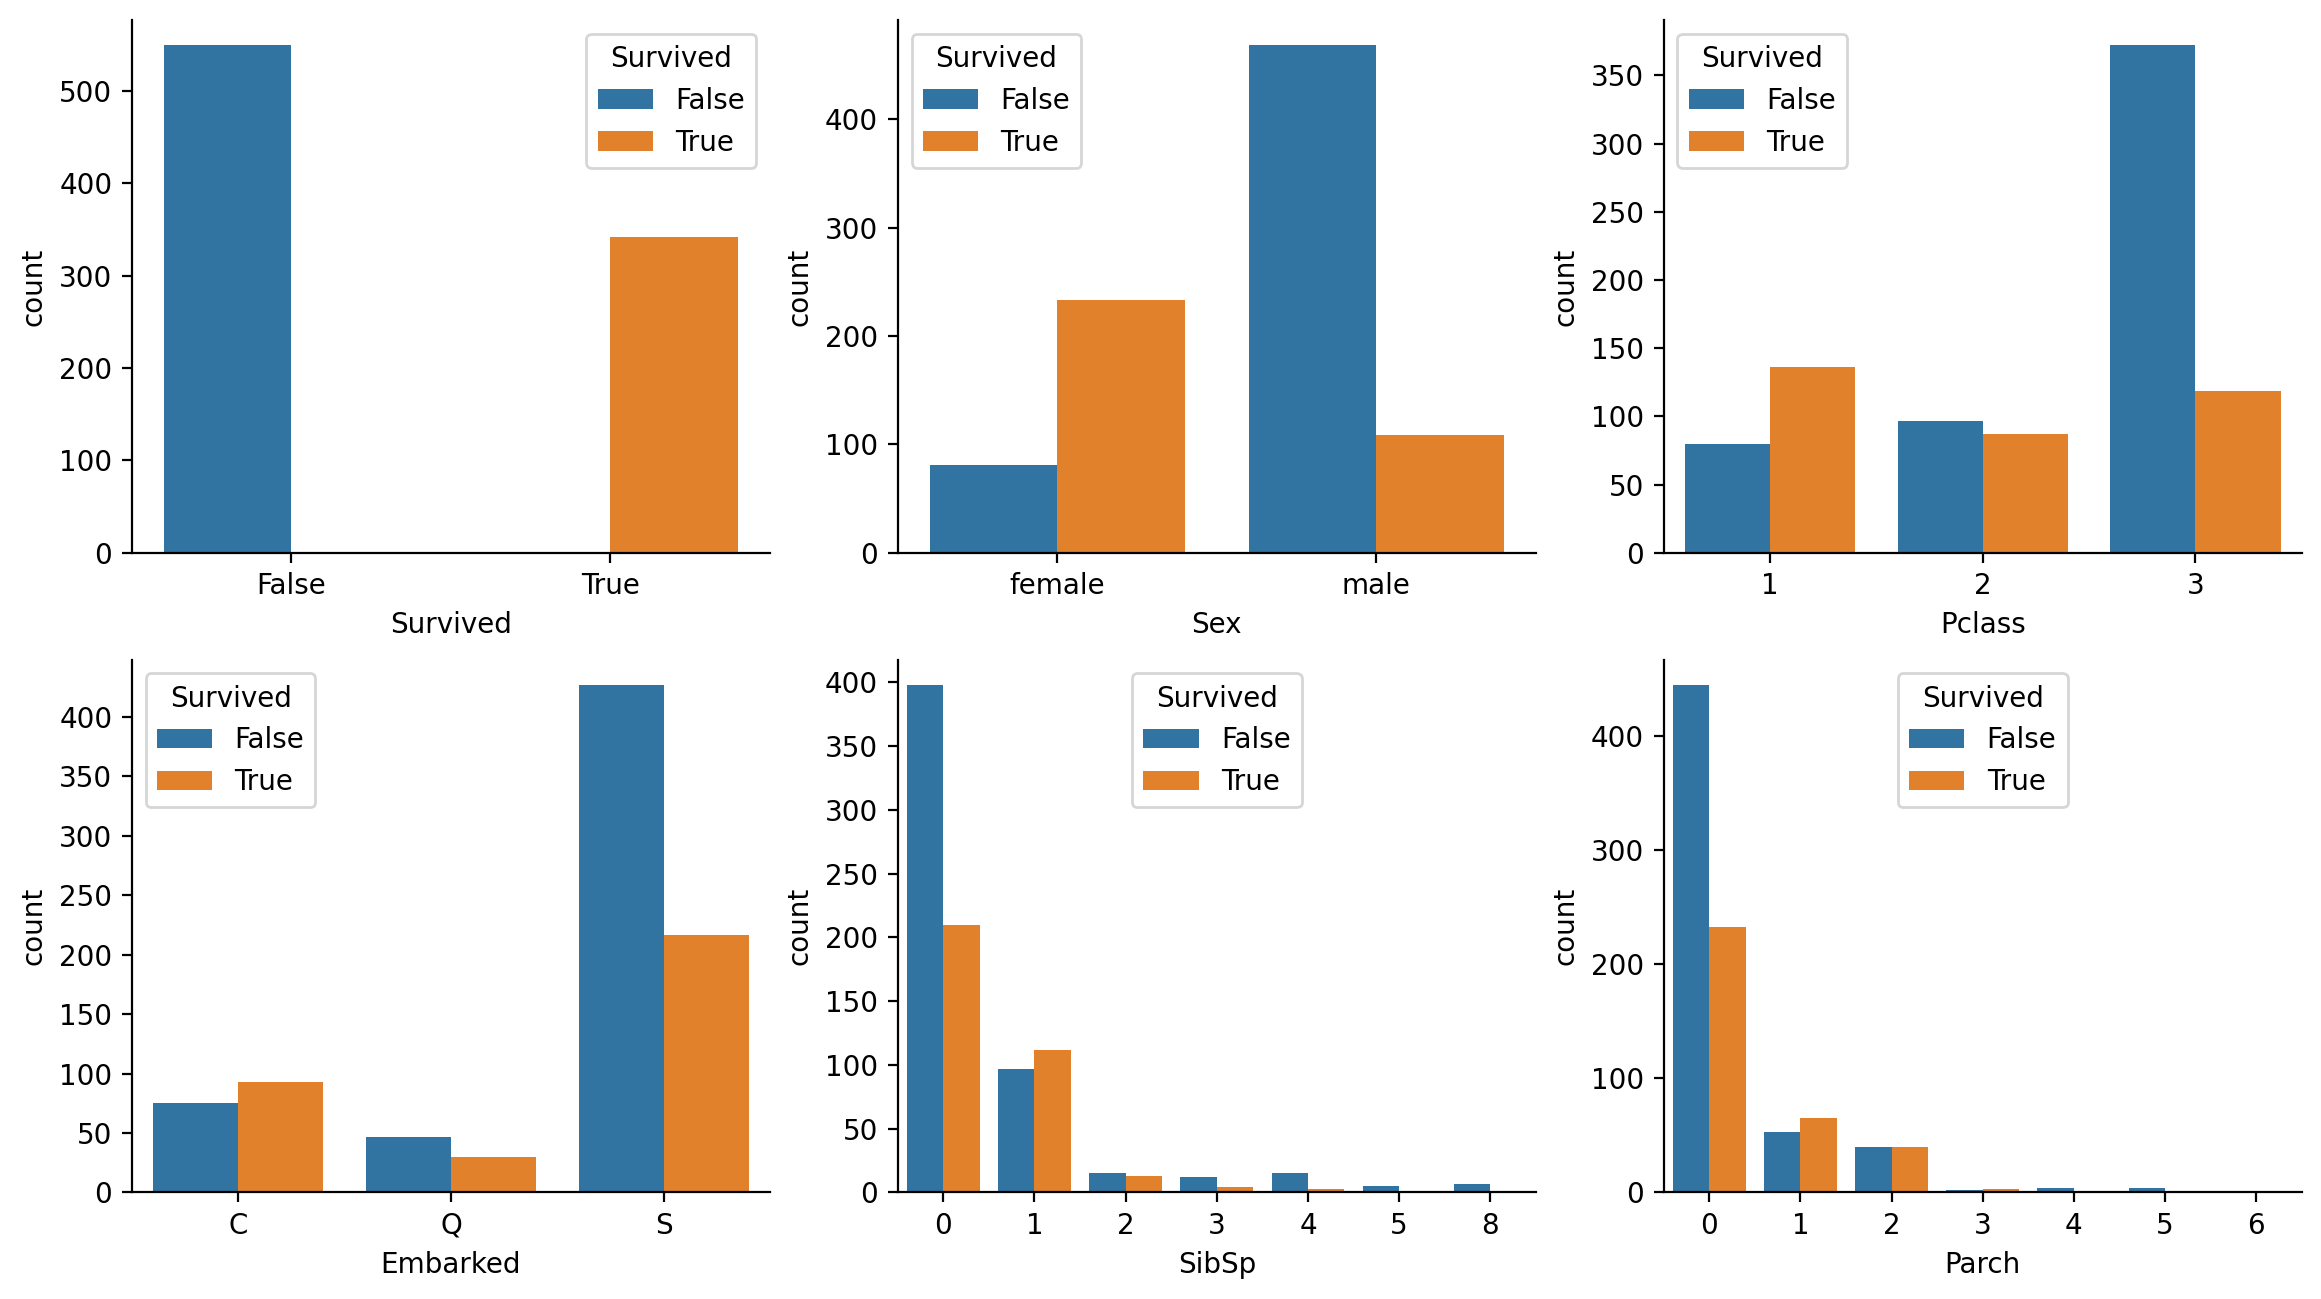

In [6]:
attributes = ['Survived', 'Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']

plt.figure(figsize=(14, 12), dpi=200)

# 이진 분류일때만 가능하기는 하다.
for i, feature in enumerate(attributes):
  plt.subplot(3,3,i+1)
  sns.countplot(data=titanic, x=feature, hue='Survived')

sns.despine()

## 데이터 전처리


In [7]:
titanic['Name'].iloc[0:5]

PassengerId
1                              Braund, Mr. Owen Harris
2    Cumings, Mrs. John Bradley (Florence Briggs Th...
3                               Heikkinen, Miss. Laina
4         Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                             Allen, Mr. William Henry
Name: Name, dtype: category
Categories (891, object): ['Abbing, Mr. Anthony', 'Abbott, Mr. Rossmore Edward',
                           'Abbott, Mrs. Stanton (Rosa Hunt)', 'Abelson, Mr. Samuel', ..., 'de Pelsmaeker, Mr. Alfons',
                           'del Carlo, Mr. Sebastiano', 'van Billiard, Mr. Austin Blyler',
                           'van Melkebeke, Mr. Philemon']

In [8]:
def get_title(name):
  return re.split(',|\.', name)[1].strip()  # 정규식을 통해 가운데 있는 정보 추출

In [9]:
# 이름에서 호칭(appellation) 추출
titanic['title'] = titanic['Name'].apply(get_title)

In [10]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
PassengerId,,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [11]:
# 호칭이 생존에 과연 어떤 ㅎ영향을 끼치는 지 확인하기 위해서 집계함수 -> 카운트 평균
titles = titanic.groupby('title').agg({'Survived' : ['count', 'mean']})

In [12]:
# Survived 컬럼 레이어 정리
titles.columns = titles.columns.droplevel()

In [13]:
# 생존 평균이 높은 순으로 정렬
titles.sort_values('mean', ascending=False)

,count,mean
title,,
the Countess,1,1.000000
Mlle,2,1.000000
Sir,1,1.000000
Ms,1,1.000000
Lady,1,1.000000
Mme,1,1.000000
Mrs,125,0.792000
Miss,182,0.697802
Master,40,0.575000


In [14]:
# 호칭 추출이 되지 않은 title 값을 Other로 처리
uncommon_titles = (['Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 
                    'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 
                    'the Countess', 'Jonkheer'])

titanic['title'] = titanic['title'].replace(uncommon_titles, 'other')

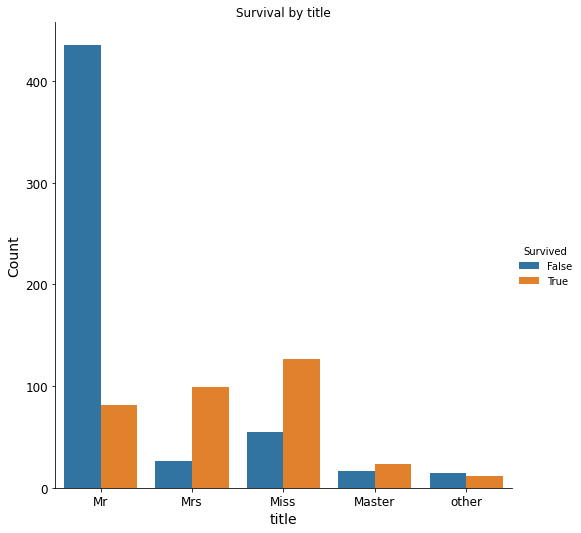

In [15]:
sns.catplot(x='title', kind='count', hue='Survived', 
            data=titanic, height=7)
plt.tick_params(labelsize=12)
plt.ylabel('Count', fontsize=14)
plt.xlabel('title', fontsize=14)
plt.title('Survival by title')
plt.show()

In [16]:
# 가족 사이즈(fam_size) 
# <- SibSp(동승한 자매 or 배우자) + Parch(동승한 부모 or 자식수) 두 개의 특성을 합쳐서 부각시킨다.

titanic['fam_size'] = titanic['SibSp'] + titanic['Parch']

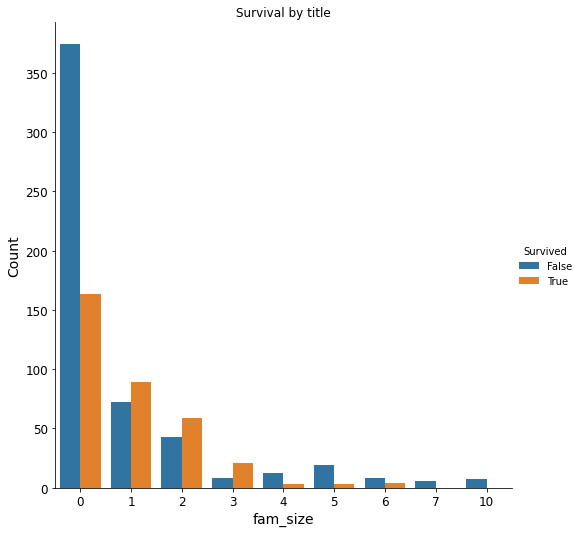

In [17]:
sns.catplot(x='fam_size', kind='count', hue='Survived', 
            data=titanic, height=7)
plt.tick_params(labelsize=12)
plt.ylabel('Count', fontsize=14)
plt.xlabel('fam_size', fontsize=14)
plt.title('Survival by title')
plt.show()

## 머신러닝(ML)을 위한 전처리

In [18]:
# 텍스트 데이터 삭제
titanic = titanic.drop(['Name','Ticket','Cabin', 'Embarked','title'], axis=1)

In [19]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size
PassengerId,,,,,,,,
1,False,3,male,22.0,1,0,7.2500,1
2,True,1,female,38.0,1,0,71.2833,1
3,True,3,female,26.0,0,0,7.9250,0
4,True,1,female,35.0,1,0,53.1000,1
5,False,3,male,35.0,0,0,8.0500,0


In [20]:
# 여성을 1로 남성을 0으로 코딩
tmp = []
for each in titanic['Sex'] :
  if each == 'female':
    tmp.append(1)
  elif each == 'male' :
    tmp.append(0)
  else:
    tmp.append(np.nan)  # 빈공간에는 무조건 np.nan으로 채워줄 것

titanic['Sex'] = tmp  # 위험하니까 일단 주석처리

In [21]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size
PassengerId,,,,,,,,
1,False,3,0,22.0,1,0,7.2500,1
2,True,1,1,38.0,1,0,71.2833,1
3,True,3,1,26.0,0,0,7.9250,0
4,True,1,1,35.0,1,0,53.1000,1
5,False,3,0,35.0,0,0,8.0500,0


## 데이터 형변환 및 결손 데이터 처리

In [22]:
# 데이터 형 변환 (소수점)
titanic['Pclass'] = titanic['Pclass'].astype('float')
titanic['Sex'] = titanic['Sex'].astype('float')
titanic['SibSp'] = titanic['SibSp'].astype('float')
titanic['Parch'] = titanic['Parch'].astype('float')
titanic['Fare'] = titanic['Fare'].astype('float')

#null(결손) 값인 경우 삭제
titanic = titanic[titanic['Survived'].notnull()]
titanic = titanic[titanic['Age'].notnull()]
titanic = titanic[titanic['SibSp'].notnull()]
titanic = titanic[titanic['Parch'].notnull()]
titanic = titanic[titanic['Fare'].notnull()]

titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    bool   
 1   Pclass    714 non-null    float64
 2   Sex       714 non-null    float64
 3   Age       714 non-null    float64
 4   SibSp     714 non-null    float64
 5   Parch     714 non-null    float64
 6   Fare      714 non-null    float64
 7   fam_size  714 non-null    int64  
dtypes: bool(1), float64(6), int64(1)
memory usage: 45.3 KB


## 데이터 분리하기 X(문제집), y(정답)

In [23]:
titanic_labels = titanic['Survived'].copy()
titanic = titanic.drop('Survived', axis=1)

## 훈련 데이터, 테스트데이터셋분리하기

In [24]:
X_train, X_test, y_train, y_test = train_test_split(titanic,
                                                    titanic_labels, 
                                                    train_size=0.8, # test_size=0.2
                                                    random_state=7)

## 머신러닝 모델 구축

In [25]:
def plot_auc_roc(model):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### 1) LogisticRegression

In [26]:
log_reg = LogisticRegression().fit(X_train, y_train)

# 정확도 확인
print('Train data Score : ', log_reg.score(X_train, y_train))
print('Test data Score : ', log_reg.score(X_test, y_test))

Train data Score :  0.8178633975481612
Test data Score :  0.7832167832167832


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


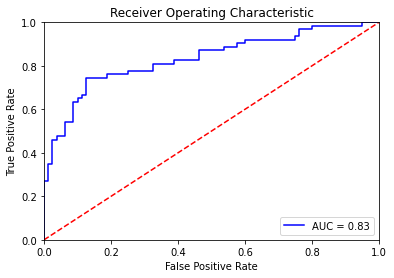

In [27]:
# Logistic Regression ROC 커브
plot_auc_roc(log_reg)

In [35]:
# Logistic Regression 평가지표
lg_y_hat = log_reg.predict(X_test)
lg_report = metrics.classification_report(y_test, lg_y_hat)
print('logistic Regression 평가지표')
print(lg_report)
print('accuracy', metrics.accuracy_score(y_test,lg_y_hat) )
print('precision', metrics.precision_score(y_test,lg_y_hat) )
print('recall', metrics.recall_score(y_test,lg_y_hat) )
print('f1', metrics.f1_score(y_test,lg_y_hat) )

logistic Regression 평가지표
              precision    recall  f1-score   support

       False       0.76      0.89      0.82        80
        True       0.82      0.65      0.73        63

    accuracy                           0.78       143
   macro avg       0.79      0.77      0.77       143
weighted avg       0.79      0.78      0.78       143

accuracy 0.7832167832167832
precision 0.82
recall 0.6507936507936508
f1 0.7256637168141592


### 2) Decision Tree

In [28]:
tree = DecisionTreeClassifier(max_depth=5,
                              min_samples_leaf=20,
                              min_samples_split=40).fit(X_train, y_train)

# 정확도 확인
print('Train data Score : ', tree.score(X_train, y_train))
print('Test data Score : ', tree.score(X_test, y_test))

Train data Score :  0.830122591943958
Test data Score :  0.7622377622377622


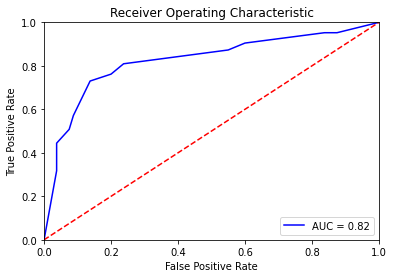

In [29]:
# Logistic DecisionTree ROC커브
plot_auc_roc(tree)

In [36]:
# Logistic DecisionTree 평가지표
tree_y_hat = tree.predict(X_test)
tree_report = metrics.classification_report(y_test, tree_y_hat)
print('Logistic DecisionTree 평가지표')
print(tree_report)
print('accuracy', metrics.accuracy_score(y_test,tree_y_hat) )
print('precision', metrics.precision_score(y_test,tree_y_hat) )
print('recall', metrics.recall_score(y_test,tree_y_hat) )
print('f1', metrics.f1_score(y_test,tree_y_hat) )

Logistic DecisionTree 평가지표
              precision    recall  f1-score   support

       False       0.73      0.91      0.81        80
        True       0.84      0.57      0.68        63

    accuracy                           0.76       143
   macro avg       0.78      0.74      0.75       143
weighted avg       0.78      0.76      0.75       143

accuracy 0.7622377622377622
precision 0.8372093023255814
recall 0.5714285714285714
f1 0.679245283018868


### 3) GradientBoostingClassifier

In [30]:
boost = GradientBoostingClassifier(max_depth=3,
                                   learning_rate=0.05).fit(X_train, y_train)

# 정확도 확인
print('Train data Score : ', boost.score(X_train, y_train))
print('Test data Score : ', boost.score(X_test, y_test))

Train data Score :  0.8914185639229422
Test data Score :  0.7832167832167832


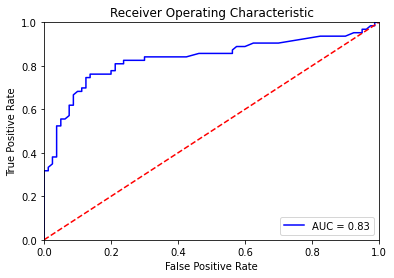

In [31]:
# GradientBoostingClassifier ROC커브
plot_auc_roc(boost)

In [37]:
# GradientBoostingClassifier 평가지표
boost_y_hat = boost.predict(X_test)
boost_report = metrics.classification_report(y_test, boost_y_hat)
print('GradientBoostingClassifier 평가지표')
print(boost_report)
print('accuracy', metrics.accuracy_score(y_test,boost_y_hat) )
print('precision', metrics.precision_score(y_test,boost_y_hat) )
print('recall', metrics.recall_score(y_test,boost_y_hat) )
print('f1', metrics.f1_score(y_test,boost_y_hat) )

GradientBoostingClassifier 평가지표
              precision    recall  f1-score   support

       False       0.75      0.93      0.83        80
        True       0.86      0.60      0.71        63

    accuracy                           0.78       143
   macro avg       0.81      0.76      0.77       143
weighted avg       0.80      0.78      0.78       143

accuracy 0.7832167832167832
precision 0.8636363636363636
recall 0.6031746031746031
f1 0.7102803738317757


### 4) RandomForestClassifier

In [34]:
random = RandomForestClassifier(n_estimators=100,
                                random_state=0).fit(X_train, y_train)

# 정확도 확인
print('Train data Score : ', random.score(X_train, y_train))
print('Test data Score : ', random.score(X_test, y_test))

# 컬럼이 많을수록 좋았다.

Train data Score :  0.9929947460595446
Test data Score :  0.7482517482517482


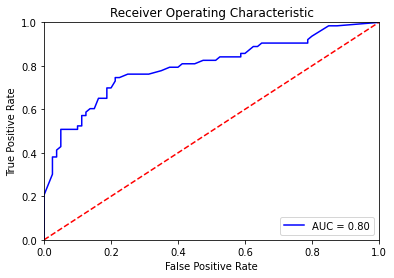

In [33]:
# RandomForestClassifier ROC커브
plot_auc_roc(random)

In [38]:
# RandomForestClassifier 평가지표
random_y_hat = random.predict(X_test)
random_report = metrics.classification_report(y_test, random_y_hat)
print('GradientBoostingClassifier 평가지표')
print(boost_report)
print('accuracy', metrics.accuracy_score(y_test,random_y_hat) )
print('precision', metrics.precision_score(y_test,random_y_hat) )
print('recall', metrics.recall_score(y_test,random_y_hat) )
print('f1', metrics.f1_score(y_test,random_y_hat) )

GradientBoostingClassifier 평가지표
              precision    recall  f1-score   support

       False       0.75      0.93      0.83        80
        True       0.86      0.60      0.71        63

    accuracy                           0.78       143
   macro avg       0.81      0.76      0.77       143
weighted avg       0.80      0.78      0.78       143

accuracy 0.7482517482517482
precision 0.7755102040816326
recall 0.6031746031746031
f1 0.6785714285714285


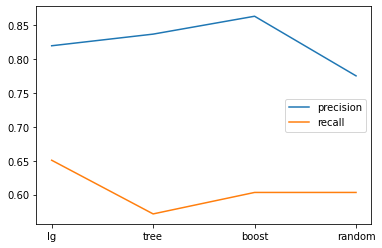

In [39]:
precision_list = []
recall_list = []

# precision 우리가 예측한 사람중에 실재 양성인 사람이 있는 비율
# recall 실재중에 우리가 예측한 양성이 있는 비율

precision_list.append(metrics.precision_score(y_test, lg_y_hat))
recall_list.append(metrics.recall_score(y_test, lg_y_hat))

precision_list.append(metrics.precision_score(y_test, tree_y_hat))
recall_list.append(metrics.recall_score(y_test, tree_y_hat))

precision_list.append(metrics.precision_score(y_test, boost_y_hat))
recall_list.append(metrics.recall_score(y_test, boost_y_hat))

precision_list.append(metrics.precision_score(y_test, random_y_hat))
recall_list.append(metrics.recall_score(y_test, random_y_hat))

# 사망했다고 예측했는데 살아있는 경우가 문제가 되는 경우 recall
# 틀려도 타격이 별로 없는 경우 precision
# 심장병이기 때문에 recall을 선택했어야 했다.
# 사실 precision이  00% 이상이면서 recall이 00% 이상인 모델을 선택해야 한다.
# 라고 하는 기준점이 존재한다.
plt.plot(['lg', 'tree', 'boost', 'random'], precision_list, label='precision')
plt.plot(['lg', 'tree', 'boost', 'random'], recall_list, label='recall')
plt.legend()
plt.show()

# 사망, 진료 등은 recall(재현율) 잘못 판단했을 때 critical할 경우, 
# 추천 알고리즘은 precision(정밀도) 잘 맞추는 게 중요 몇개 틀려도 별 문제가 없을 때
# 둘 다 중요하다면 f1스코어로 봐야 한다.